In [100]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf
from os.path import expanduser, join, abspath
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.types import StructField
import numpy as np
import pandas as pd
import matplotlib.dates as mdate

In [101]:
warehouse_location = abspath('/user/hive/warehouse')

In [102]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .master("spark://app-13:7077") \
    .getOrCreate()
df = spark.read.format("CSV").option("header","true").\
option("timestampFormat ","yyyy-MM-dd'T'HH").\
schema("user_id int,item_id int,behavior_type int,user_geohash string,item_category int,create_time string").\
load("/user/hive/warehouse/test.db/tianchi/tianchi_mobile_recommend_train_user.csv") 
df.createOrReplaceTempView("taobao")

In [104]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [103]:
sqlDF2 = spark.sql("SELECT date(to_timestamp(create_time)) as create_day, count(*) as pbcf FROM taobao group by date(to_timestamp(create_time)) order by date(to_timestamp(create_time))").cache()

In [105]:
sqlDF2.createOrReplaceTempView("pbcf")

In [107]:
sqlDF = spark.sql("select cast(create_day as string)as create_day, pbcf  from pbcf").cache()
sqlDF.show()

+----------+------+
|create_day|  pbcf|
+----------+------+
|2014-11-18|366701|
|2014-11-19|358823|
|2014-11-20|353429|
|2014-11-21|333104|
|2014-11-22|361355|
|2014-11-23|382702|
|2014-11-24|378342|
|2014-11-25|370239|
|2014-11-26|360896|
|2014-11-27|371384|
|2014-11-28|340638|
|2014-11-29|364697|
|2014-11-30|401620|
|2014-12-01|394611|
|2014-12-02|405216|
|2014-12-03|411606|
|2014-12-04|399952|
|2014-12-05|361878|
|2014-12-06|389610|
|2014-12-07|399751|
+----------+------+
only showing top 20 rows



In [108]:
pbcfPandasDF = sqlDF.toPandas()

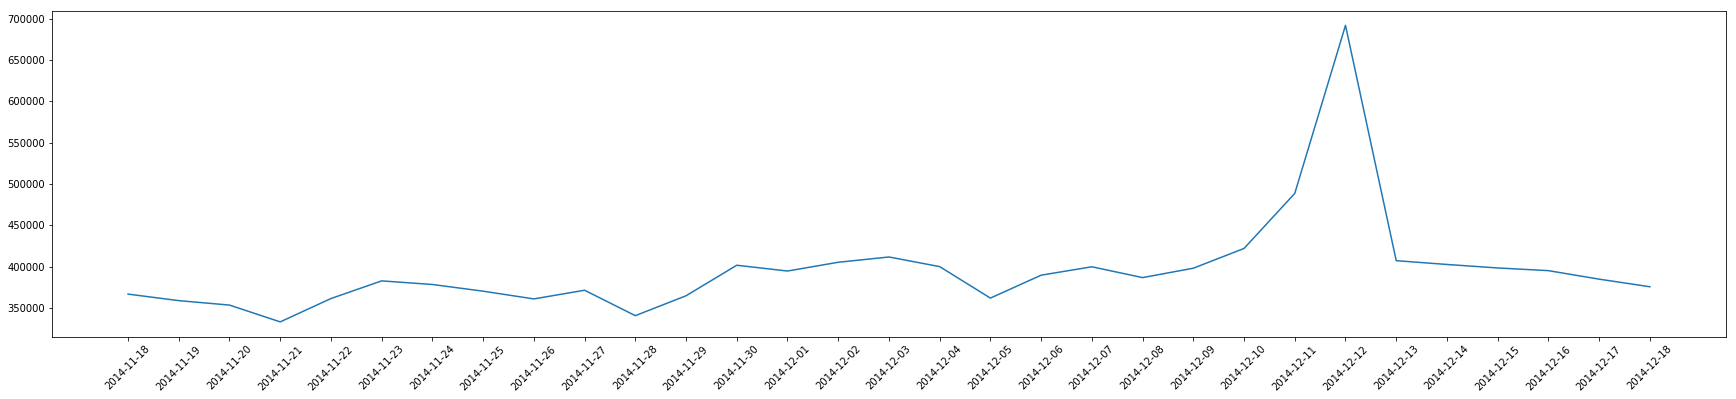

In [109]:
fig=plt.figure(figsize=(30,6))
ax=fig.add_subplot(1,1,1)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
date_series=pd.date_range(pbcfPandasDF['create_day'][0],pbcfPandasDF['create_day'][30],freq='D')
plt.xticks(date_series,rotation=45)
ax.plot(date_series,pbcfPandasDF.set_index('create_day'))
plt.show()